### Task 1: Exploratory Data Analysis (EDA)

<Axes: >

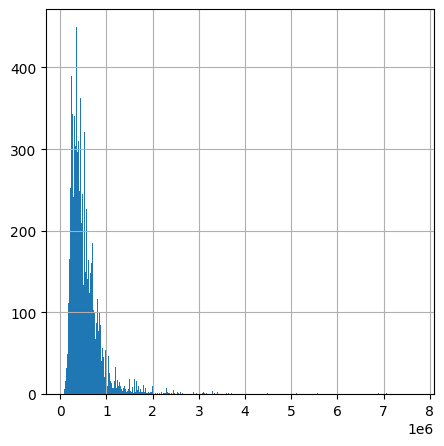

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Sales = pd.read_csv("House_Sales_Dataset.csv")

Sales["estimated_value"].hist(bins=1000, figsize=(5, 5))


The majority of the data is on the left side due to the general price of houses being low. Since there are outliers in our data, the histograph is heavily skewed right. This means that there are outliers that are much more expensive than the rest of the data.


array([[<Axes: xlabel='living_units', ylabel='living_units'>,
        <Axes: xlabel='baths', ylabel='living_units'>,
        <Axes: xlabel='interior_size', ylabel='living_units'>,
        <Axes: xlabel='estimated_value', ylabel='living_units'>,
        <Axes: xlabel='lot_size', ylabel='living_units'>,
        <Axes: xlabel='num_floors', ylabel='living_units'>,
        <Axes: xlabel='year_built', ylabel='living_units'>],
       [<Axes: xlabel='living_units', ylabel='baths'>,
        <Axes: xlabel='baths', ylabel='baths'>,
        <Axes: xlabel='interior_size', ylabel='baths'>,
        <Axes: xlabel='estimated_value', ylabel='baths'>,
        <Axes: xlabel='lot_size', ylabel='baths'>,
        <Axes: xlabel='num_floors', ylabel='baths'>,
        <Axes: xlabel='year_built', ylabel='baths'>],
       [<Axes: xlabel='living_units', ylabel='interior_size'>,
        <Axes: xlabel='baths', ylabel='interior_size'>,
        <Axes: xlabel='interior_size', ylabel='interior_size'>,
        <Axes: xla

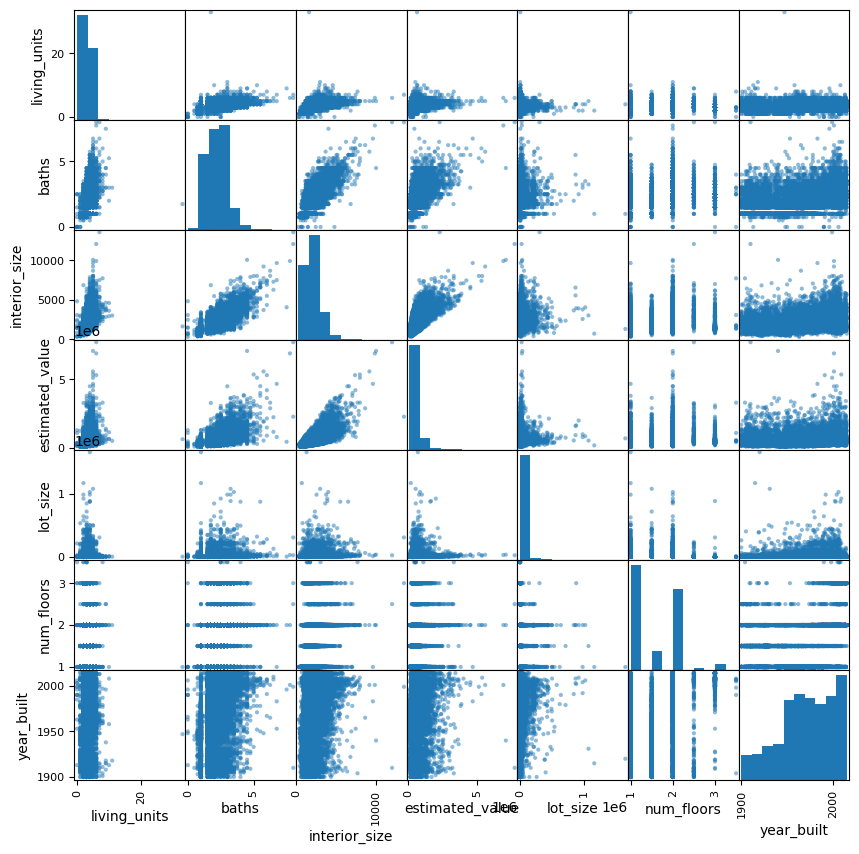

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["living_units", "baths", "interior_size", "estimated_value", "lot_size", "num_floors", "year_built"]
scatter_matrix(Sales[attributes], figsize=(10, 10))


From the rows relating to the estimated value, there is a vague correlation between interior size and estimated value. Although it is not very strong, it is the strongest correlation seen so far.


Text(0.5, 1.0, 'Correlation Heatmap')

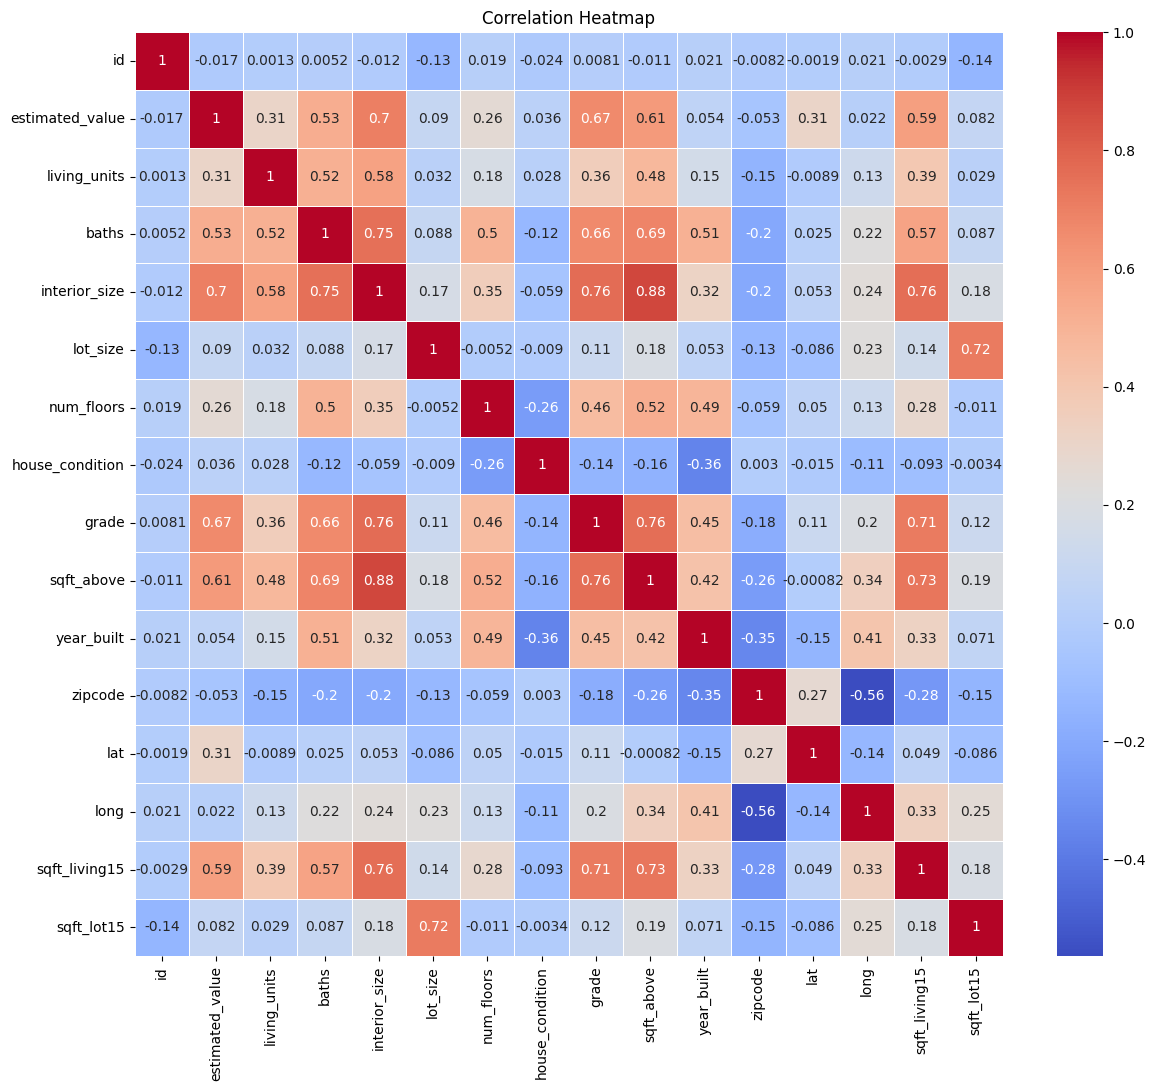

In [ ]:
corr_matrix = Sales.corr(numeric_only=True)
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.6)
plt.title('Correlation Heatmap')


The heatmap shown above further proves our analysis of the scatterplots. The highest correlation between all the features and estimated value is interior size. Close behind are grade and square feet above.

### Task 2: Data Preprocessing with Pipelines and Feature Extraction

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression

#organize into bins
Sales["value_cat"] = pd.cut(Sales["estimated_value"], bins=[0, 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])

#testing stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(Sales, Sales["value_cat"]):
  strat_train_set = Sales.iloc[train_index]
  strat_test_set = Sales.iloc[test_index]

strat_test_set["value_cat"].value_counts() / len(strat_test_set)
strat_train_set["value_cat"].value_counts() / len(strat_train_set)

#drop the label column
strat_train_set.drop("value_cat", axis=1, inplace=True)
strat_test_set.drop("value_cat", axis=1, inplace=True)##############

train = strat_train_set.drop("estimated_value", axis=1)
train_labels = strat_train_set["estimated_value"].copy()

test = strat_test_set.drop("estimated_value", axis=1)
test_labels = strat_test_set["estimated_value"].copy()

num_std_attribs = ['living_units', 'baths', 'interior_size', 'lot_size', 'num_floors', 'house_condition', 'grade', 'sqft_above', 'year_built', 'zipcode', 'sqft_lot15', 'sqft_living15']
num_maxmin_attribs = ['long', "lat"]
cat_attribs = ["has_waterfront", "scenic_view"]

std_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('stdscaler', StandardScaler()),
])

minmax_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('minmaxscaler', MinMaxScaler()),
])

cat_pipeline = Pipeline([('onehot', OneHotEncoder())])

def fit_and_print(p, train_set, train_labels, test_set, test_labels):
  p.fit(train_set, train_labels)
  train_preds = p.predict(train_set)
  test_preds = p.predict(test_set)
  print("Training Error MAE: " + str(mean_absolute_error(train_preds, train_labels)))
  print("Test Error MAE: " + str(mean_absolute_error(test_preds, test_labels)))
  print("R2 score: " + str(r2_score(test_preds, test_labels)))

<ipython-input-143-14b15137b9cd>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_train_set.drop("value_cat", axis=1, inplace=True)
<ipython-input-143-14b15137b9cd>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_test_set.drop("value_cat", axis=1, inplace=True)


The code above shows the lengthy process of Data Preprocessing to the pipeline. It is important to notice that the different attributes that will be learnt by the machine.

In [ ]:
from sklearn.compose import ColumnTransformer

full_transformer = ColumnTransformer([('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                ('numeric_minmaxpreprocessing', minmax_pipeline, num_maxmin_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                ])

p1_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
                        ('linear_regression', LinearRegression())
                      ])

fit_and_print(p1_full_pipeline, train, train_labels, test, test_labels)

Training Error MAE: 126900.33512514643
Test Error MAE: 125823.745876848
R2 score: 0.6349695367766414


According to the Training Error and Test Error shown above, the machine is doing a mediocre job of predicting values. Since the values in the model are of normal housing and not mansion houses (costing millions of dollars), it is not good for them to be around $126,000 off. However, the R2 score shows that the machine is adequately guessing 63.5% of the data. Although we are on the right track, there is much room for imporvement.

###Task 3: Train Regression Models

In [ ]:
#linear regression
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

num_attribs = num_std_attribs + num_maxmin_attribs

#Polynomial Features
poly_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('poly_features', PolynomialFeatures(degree=2, include_bias=False))
                          ])

full_transformer_poly = ColumnTransformer([ ('poly_features', poly_pipeline, num_attribs),
                                            ('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
                                            ('numeric_minmaxpreprocessing', minmax_pipeline, num_maxmin_attribs),
                                            ('cat_preprocessing', cat_pipeline, cat_attribs)
                                         ])
p2_linRegression_pipeline = Pipeline([('all_column_transformation_poly', full_transformer_poly),
                        ('linear_regression', LinearRegression())
                      ])

fit_and_print(p2_linRegression_pipeline, train, train_labels, test, test_labels)

Training Error MAE: 101753.17940772758
Test Error MAE: 101786.30508326844
R2 score: 0.7664113622969013


The Error MAE scores from above show a significant decrease in the error of the machine's estimation. This is directly reflected in the R2 score jumping from 63.5% accuracy to 76.6% accurate

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


treeProcessor = ColumnTransformer([
    ('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
    ('numeric_minmaxpreprocessing', minmax_pipeline, num_maxmin_attribs),
    ('cat_preprocessing', cat_pipeline, cat_attribs)
])

tree_pipeline = Pipeline([
    ('treeProcessor', treeProcessor),
    ('tree', DecisionTreeRegressor(random_state=42))
])

fit_and_print(tree_pipeline, train, train_labels, test, test_labels)



Training Error MAE: 883.2441295546558
Test Error MAE: 96312.33738144807
R2 score: 0.7603726630578516


After using the decision tree, the R2 score has stayed relatively the same, but erros for each have differed drastically. The training error being significantly lower indicates that the model is overfitting the data. Even though both errors are lower, it is important to notice that the the R2 does not change much.

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

forestPreProcessor = ColumnTransformer([
    ('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
    ('numeric_minmaxpreprocessing', minmax_pipeline, num_maxmin_attribs),
    ('cat_preprocessing', cat_pipeline, cat_attribs)
])

rf_pipeline = Pipeline([
    ('forestPreProcessor', forestPreProcessor),
    ('rf', RandomForestRegressor(random_state=42))
])

fit_and_print(rf_pipeline, train, train_labels, test, test_labels)

Training Error MAE: 26038.18269467556
Test Error MAE: 67688.62889961776
R2 score: 0.8587422785933285


After using the Random Forest regression on the model, the accuracy has jumped up to 85.9% This is the highest R2 score so far. However, there is still some overfitting ocurring as seen by the difference in Training and Testing error.

In [ ]:
#Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

ridge_preprocessor = ColumnTransformer([
    ('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
    ('numeric_minmaxpreprocessing', minmax_pipeline, num_maxmin_attribs),
    ('cat_preprocessing', cat_pipeline, cat_attribs)
])

ridge_pipeline = Pipeline([
    ('ridge_preprocessor', ridge_preprocessor),
    ('ridge', Ridge(random_state=42))
])

fit_and_print(ridge_pipeline, train, train_labels, test, test_labels)

Training Error MAE: 126882.74395493479
Test Error MAE: 125808.65860848887
R2 score: 0.6348447225405561


When using the Ridge Regression for our model, we can see that the overfitting issue has been fixed, but at the expense of the R2 score going down.

In [ ]:
#Lasso Regression
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

lasso_preprocessor = ColumnTransformer([
    ('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
    ('numeric_minmaxpreprocessing', minmax_pipeline, num_maxmin_attribs),
    ('cat_preprocessing', cat_pipeline, cat_attribs)
])

lasso_pipeline = Pipeline([
    ('lasso_preprocessor', lasso_preprocessor),
    ('lasso', Lasso( random_state=42))
])

fit_and_print(lasso_pipeline, train, train_labels, test, test_labels)

Training Error MAE: 126898.85883922483
Test Error MAE: 125822.47788488002
R2 score: 0.6349586460251572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.422e+13, tolerance: 2.410e+11
  model = cd_fast.enet_coordinate_descent(


The Lasso Regression had similar statistics to both the Ridge Regression and Linear Regression models. This may due to their tolerance to outliers or other factors within the data.

###Task 4: Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {'lasso__alpha': [0.1, 1.0, 10.0, 100.0]}

# Instantiate GridSearchCV
grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Perform the grid search
grid_search.fit(train, train_labels)

print("Best parameters found:")
print(grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.770e+13, tolerance: 1.967e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e+13, tolerance: 1.926e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e+13, tolerance: 1.870e

Best parameters found:
{'lasso__alpha': 100.0}


I decided to use the grid search on the Lasso regression model because it was one that needed to be improved and it was the most recent one I coded. The parameter that was found was changing alpha to 100 from iits default 1.

In [ ]:
#Lasso Regression 2.0
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

lasso_preprocessor = ColumnTransformer([
    ('numeric_stdpreprocessing', std_pipeline, num_std_attribs),
    ('numeric_minmaxpreprocessing', minmax_pipeline, num_maxmin_attribs),
    ('cat_preprocessing', cat_pipeline, cat_attribs)
])

lasso_pipeline = Pipeline([
    ('lasso_preprocessor', lasso_preprocessor),
    ('lasso', Lasso(random_state=42, alpha=100))
])

fit_and_print(lasso_pipeline, train, train_labels, test, test_labels)

Training Error MAE: 126776.80542440682
Test Error MAE: 125741.5875202486
R2 score: 0.6338424186638505


After modifying the code using the new parameters, there was minimal change. Thus, it can be inferred that the alpha parameter did not instigate a change in the model.

###Task 5: Model Evaluation

**Linear Regression Model**
```
Training Error MAE: 101753.17940772758
Test Error MAE: 101786.30508326844
R2 score: 0.7664113622969013
```
The linear regression was the hardest one to implement since it was the first one, but made a strong attempt by being stronger than average in predicting power. This may occur because it is simply not the right fit for this specific data.


**Decision Tree Regression Model**
```
Training Error MAE: 883.2441295546558
Test Error MAE: 96312.33738144807
R2 score: 0.7603726630578516
```
While the Decision Tree Regression Method did do better than the linear regression model, it was clear that it was suffering from overfitting the data. This became clear when the Training Error and Test Error was put side by side.

**Random Forest Regression Model**
```
Training Error MAE: 26038.18269467556
Test Error MAE: 67688.62889961776
R2 score: 0.8587422785933285
```
The Random Forest Regression Model was, by far, the best of all the models. Although it did see overfitting in its predictions, the R2 score achieved 85.9%. This may be due to the Model being more tolerable to outliers. In this case, there may be the chance that this model is *too* tolerant to outliers.

**Ridge Regression Model**
```
Training Error MAE: 126882.74395493479
Test Error MAE: 125808.65860848887
R2 score: 0.6348447225405561
```
The Ridge regression model suffered the same as the linear regression model did, unfortunately. They scored very similar scores in all categories. This may be due to a lack of tolerance when it comes to outliers.

**Lasso Regression Model**
```
Training Error MAE: 126898.85883922483
Test Error MAE: 125822.47788488002
R2 score: 0.6349586460251572
```
The Ridge regression model suffered the same as the linear regression model and the Ridge regression model did. All three scored very similar scores in all categories. This may be due to a lack of tolerance when it comes to outliers in all models.

###Conclusion
Overall, this project helped me understand better how to create and train models for predicting data. The Random Forest emerged the best in terms of balancing Error and R2 score. However, it is important to note that more improvements can be made. An example of this is hyperparameter optimization techniques for all the models. To conclude, the project successfully taught me better how to manage systems and consistently make them better.